# Semi-Supervised Learning (SSL)

## Author : Vincent HERFELD


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
import pandas as pd
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 2.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 0.6

# Threshold eps for epsilon graphs
params['eps'] = 0.3

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 0

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1e4
params['c_u'] = 0.1

In [5]:
def compute_hfs(L, Y, soft=False, show_balance =False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl) - 1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    for i in range(num_classes):
        y[:, i]  =np.where(Y == i+1, 1, -1)
        
    l_idx = Y != 0
    u_idx = Y == 0
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        F = np.zeros((num_samples, num_classes))
        for i in range(num_classes):
            y_i = y[:, i]
            f_l = y_i[l_idx] 
            
            if show_balance:
                df = pd.DataFrame()
                df["labels"] = f_l
                occurrences = df['labels'].value_counts()
        
                display(occurrences)
            
            Lu = L[u_idx, :] #bottom lines of the laplacian
            Luu = Lu[:, u_idx] #left bottom corner of the laplacian
            Lul = Lu[:, l_idx] #right bottom corner of the laplacian
            f_u = np.linalg.inv(Luu) @ (-Lul @ f_l)
            f = np.zeros_like(Y)
            f[l_idx] = f_l
            f[u_idx] = f_u
            F[:, i] = f 
            
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        F = np.zeros((num_samples, num_classes))
        for i in range(num_classes):
            y_i = y[:,i]
            d = np.where(l_idx, params['c_l'], params['c_u'])
            C = np.diag(d)
            f = np.linalg.inv(np.linalg.inv(C) @ L + params['laplacian_regularization'] * np.eye(C.shape[0])) @ y_i
            F[:, i] = f
    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    
    labels = np.argmax(F, axis=1) + 1  
    return labels, F


In [6]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    L = build_laplacian_regularized(X, laplacian_regularization = params['laplacian_regularization'], var=params['var'], eps=params['eps'], k=params['k'], laplacian_normalization=params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

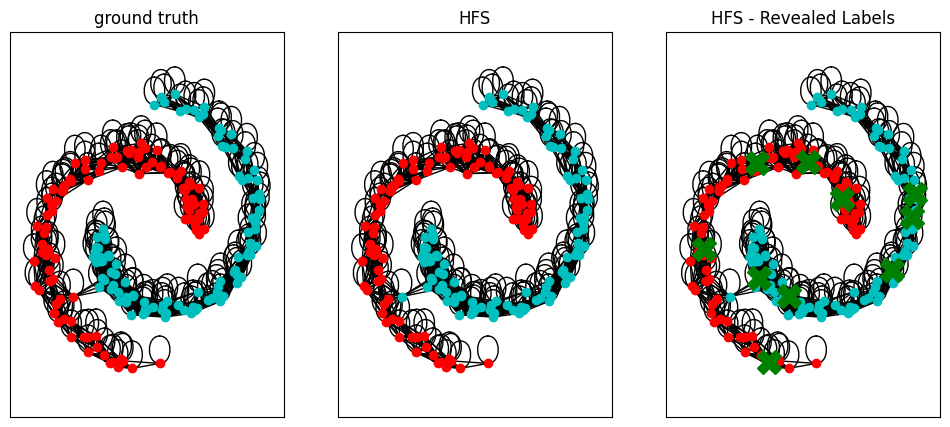

Soft=False, Accuracy=0.995


In [7]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [8]:
np.random.seed(None)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                      dataset='data_2moons_hfs_large.mat',
                                                      plot=False, seed=None, **params)
    
mask_labels  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


AssertionError: only one class in training data!

Since we mask every data point except 4 sometimes these 4 can be of the same class and thus the algorithm will not work. There is an "assert" call that makes sure that there are at least 2 classes (2 different labels) in the unmasked labels.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

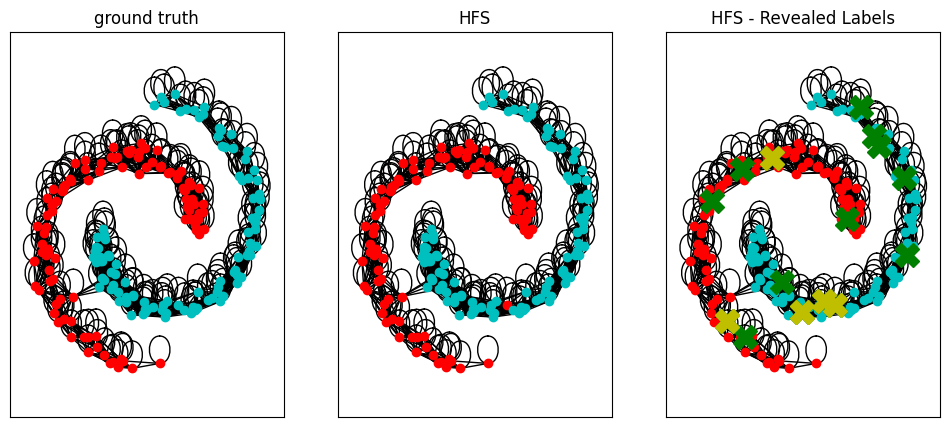

Soft=False, Accuracy=0.995


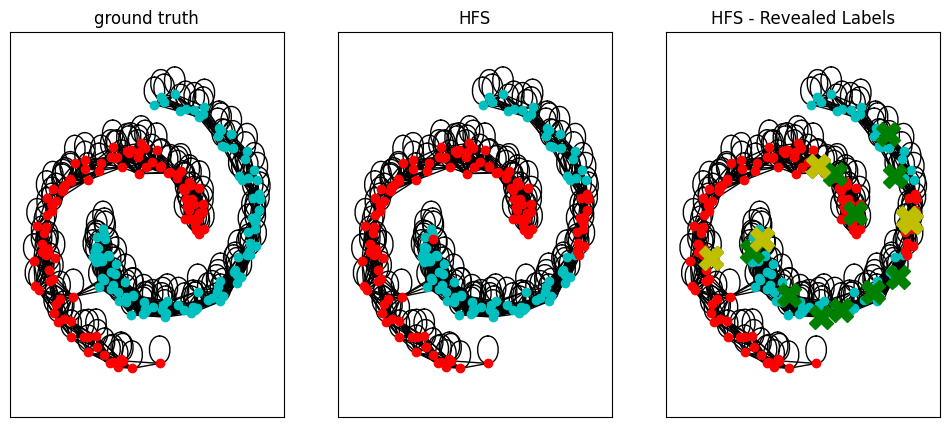

Soft=True, Accuracy=0.925


In [9]:
# Comparing
seed = None  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

In this run we notice that the soft HFS is more robust to noise than the hard HFS (this is not the case with all runs since noise is quite low).

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

To manage more than two classes we build a OnevsMany Classifier, this means that we have a num_classes binary classifiers. So we compute a HFS for each class $i$ where the labels are binarized such that elements labeled by $i$ are set to 1 and all the other labels are set to 0. This gives us a harmonic function on the graph that we can consider to be probabilities of belonging to class $i$. We then pick the class with highest probability.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person).
 
For the small dataset I obtain 0.84 accuracy with 40% of observed labels.

For the augmented dataset I obtain 0.65 accuracy with 8% of observed labels.

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

In [10]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [11]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

/var/folders/c0/d3_lqdr53vs56db95whhzj280000gn/T/ipykernel_24472/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


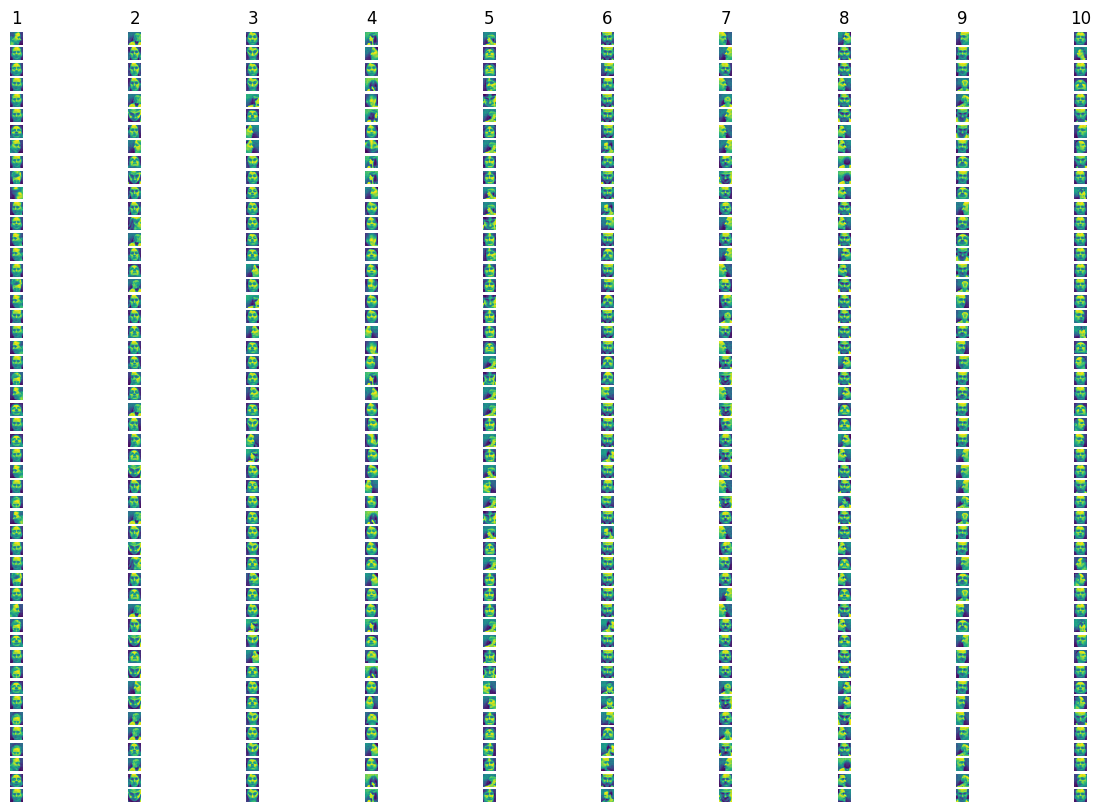

In [12]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
#plot_image_data(images)
#print(images.shape)
#print(masked_labels.reshape(-1, 10))

In [13]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 2e-1
params_face_rec['var'] = 1e2
params_face_rec['eps'] = 0
params_face_rec['k'] = 6
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 1e1
params_face_rec['c_u'] = 1e-3

In [14]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Percent of observed labels : 40.0 %
Accuracy =  0.84
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  9  9  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6 10  8
  1 10 10  2  4  4  5  4  7  8  1 10  1  2  3 10  5  6  7  3  9 10  1  2
 10  4  5  6  7  3  9 10  4  4  3  4  5  6  8  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7

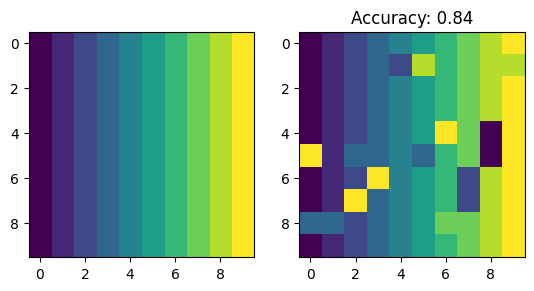

In [15]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print(f"Percent of observed labels : {100*np.count_nonzero(masked_labels) / len(masked_labels)} %")
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

Percent of observed labels : 8.0 %
Accuracy =  0.65
[ 0.  0.  0.  0.  0.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.
  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  7.  8.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.
  0.  0.  1.  2.  3.  0.  0.  0.  0.  0.  9.  0.  0.  2.  0.  0.  5.  6.
  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  2.  0.  0.  5.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

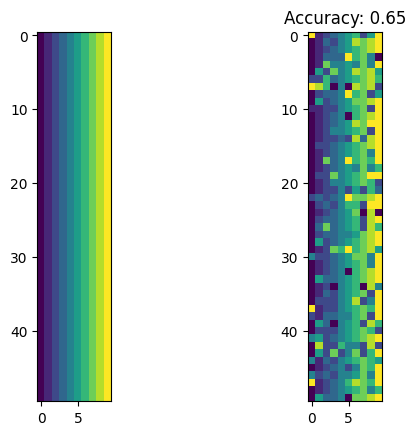

In [16]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.5*1e-2
params_face_rec['var'] = 80
params_face_rec['eps'] = 0
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'sym'
params_face_rec['c_l'] = 1e3
params_face_rec['c_u'] = 1e-3

# graph Laplacian
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f_a = compute_hfs(L, masked_labels_a, soft=False, **params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()
print(f"Percent of observed labels : {100*np.count_nonzero(masked_labels_a) / len(masked_labels_a)} %")
print("Accuracy = ", accuracy)

print(masked_labels_a)

print(predicted_labels_a)
print(labels_a)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition



In [18]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 7
params_online_ssl['var'] = 1e4
params_online_ssl['eps'] = 0
params_online_ssl['k'] = 5
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 1e3
params_online_ssl['c_u'] = 1e-1

In [19]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=30):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """
        thresh = 40
        assert (self.image_dimension == len(face)), "new image not of good size"

        distances = distance.cdist(face.reshape(1,-1), self.centroids)

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            c_rep, c_add = None, None
            
            sorted_centroids = np.argsort(distances[0])

            c_1 = sorted_centroids[0]
            c_2 = sorted_centroids[1]

            idx = 1
            while(c_2 in self.taboo and c_1 in self.taboo): #if c_1 and c_2 are in self.taboo we change c_2 until it is no longer in self.taboo
                idx +=1 
                c_2 = sorted_centroids[idx]
            
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            else:
                # If both c_1 and c_2 are not in self.taboo, select the one with the largest multiplicity as c_rep
                if self.V[c_1] > self.V[c_2]:
                    c_rep = c_1
                    c_add = c_2
                else:
                    c_rep = c_2
                    c_add = c_1
                    
            """
            Update data structures: self.centroids and self.V
            """
            if c_add == self.last_face or c_rep == self.last_face:
                self.V[self.last_face] += 1
            else:
                self.V[c_rep] += self.V[c_add]
                self.V[c_add] = 1
                self.centroids[c_add, :] = face
    
            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:  
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self, unknown_thresh = 0.3, min_num = 20):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        # build the similarity graph W
        W = V @ build_similarity_graph(self.centroids, var = params_online_ssl["var"], eps = params_online_ssl["eps"], k = params_online_ssl["k"]) @ V
        L = build_laplacian(W, laplacian_normalization = params_online_ssl["laplacian_normalization"])
        Q = L + params_online_ssl["laplacian_regularization"]*np.eye(W.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        next_label = num_classes
        label_scores = []
        assigned = False
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
            if score > unknown_thresh:
                assigned = True
        if not assigned:
            if not self.init:
                if self.V[self.last_face] > min_num and self.Y[self.last_face] == 0:
                    # Add automatic label only if face has not already been labeled
                    auto_label = "AutoLabel_" + str(next_label)
                    self.label_names.append(auto_label)
                    self.Y[self.last_face] = len(self.label_names)  # Update label for last face
                    next_label += 1
                else:
                    label_scores.append(("unknown", 1.0))
            else:
                label_scores.append(("unknown", 1.0))

        return label_scores
      


In [ ]:
#('vince_wo_glasses')         # choose your names here :)
#create_user_profile('mathieu')

online_face_recognition(['vince_wo_glasses', 'mathieu'], IncrementalKCenters, n_pictures=15)

Profile found with 16 images.
Profile found with 9 images.


This is the result of the face recognition. I've created 2 profiles at this point with me (vince) and my friend (mathieu).

![results](results/frame_result.png)

This is the result when finding an unknown face. This time I've created a third profile of myself without glasses and I've made more pictures of mathieu this time with his glasses. I then put on a cap and put back my glasses on so that it doesn't recognize me as "vince_wo_glasses", it works well, it recognizes mathieu but not me ! So it returns unknown.

![title](results/frame_unknown.png)

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification
 
To solve this problem I thaught about modifying how multiplicity is updated. I imagine that a face that is seen enough is actually a face that stays in the frame long enough. So what I do is not modify centroids when the face that is closest to the current face is actually the last added face but instead add to the multiplicity of that centroid. Once I have reached a sufficient multiplicity for an unlabeled centroid, we add a new label for it.

Problems I encounter is that this process starts once self.V is initialized meaning once we reach the max number of centroids. So before that happends, we eventually create several centroids all associated to the same unknown face, and once we reach the max num_centroids, we create several auto labels even though they point to a very similar face. I was unable to find a good way to avoid this (as seen in the next image).  

(the setting is same as before I have my glasses but the pictures on my profile have me without them.)

![auto](results/frame_auto.png)


    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

For my study I choose to compare a supervised learning algorithm with the semi-supervised learning algorithm we've built earlier to recognize faces with the face dataset. To do so I will train an SVM on the labeled data and then check if it can find accuratly the unlabeled labels.

/var/folders/c0/d3_lqdr53vs56db95whhzj280000gn/T/ipykernel_70756/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


Percent of observed labels : 8.0 %
Accuracy =  0.64
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.
  7.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  6.  0.  0.  0. 10.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  1.  0.
  3.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.

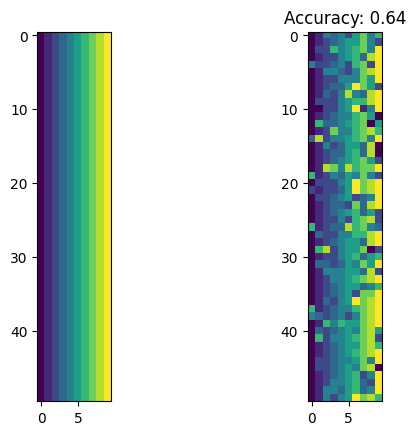

In [315]:
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data_augmented(preprocess_image)

"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.5*1e-2
params_face_rec['var'] = 80
params_face_rec['eps'] = 0
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'sym'
params_face_rec['c_l'] = 1e3
params_face_rec['c_u'] = 1e-3

# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_semi, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy_semi = np.equal(predicted_labels_semi, labels).mean()
print(f"Percent of observed labels : {100*np.count_nonzero(masked_labels) / len(masked_labels)} %")
print("Accuracy = ", accuracy_semi)

print(masked_labels)
print(predicted_labels_semi)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_semi.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy_semi))
plt.show()

In [316]:
from sklearn import svm

# Step 1: Preprocess the Data

train_images = images[masked_labels != 0] #train on the images and labels that are visible
train_labels = labels[masked_labels != 0]

print(f"The training set is of size {train_labels.shape}")

svm_classifier = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

# Train SVM using labeled faces
svm_classifier.fit(train_images, train_labels)

# Evaluate performance using appropriate metrics
accuracy_svm = svm_classifier.score(images, labels)

print(f"The accuracy of the semi-supervised classifier is of :{accuracy_semi}")
print(f"The accuracy of the supervised classifier is of : {accuracy_svm}")

The training set is of size (40,)
The accuracy of the semi-supervised classifier is of :0.64
The accuracy of the supervised classifier is of : 0.506


As we can see a SVM classifier is veru efficient as well, but we have a slightly better accuracy on the semi-supervised classifier. We can now compare other metrics such as the F1 score.

In [317]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels_svm = svm_classifier.predict(images)

# Metrics for the semi-supervised classifier
precision_semi = precision_score(labels, predicted_labels_semi, average='weighted')
recall_semi = recall_score(labels, predicted_labels_semi, average='weighted')
f1_semi = f1_score(labels, predicted_labels_semi, average='weighted')

# Metrics for the supervised classifier
precision_svm = precision_score(labels, predicted_labels_svm, average='weighted')
recall_svm = recall_score(labels, predicted_labels_svm, average='weighted')
f1_svm = f1_score(labels, predicted_labels_svm, average='weighted')

# Print the results
print("Semi-supervised classifier Precision Score:", precision_semi)
print("Semi-supervised classifier Recall Score:", recall_semi)
print("Semi-supervised classifier F1 Score:", f1_semi)
print()
print("Supervised classifier Precision Score:", precision_svm)
print("Supervised classifier Recall Score:", recall_svm)
print("Supervised classifier F1 Score:", f1_svm)

Semi-supervised classifier Precision Score: 0.6901802838688077
Semi-supervised classifier Recall Score: 0.64
Semi-supervised classifier F1 Score: 0.6472240775762788

Supervised classifier Precision Score: 0.5110560663690856
Supervised classifier Recall Score: 0.506
Supervised classifier F1 Score: 0.49165991580009755


Let's put all this in a dataframe for a nicer display.

In [318]:
import pandas as pd

data = {
    "semi-supervised": [accuracy_semi, precision_semi, recall_semi, f1_semi],
    "SVM": [accuracy_svm, precision_svm, recall_svm, f1_svm]
}
index = ["Accuracy", "Precision", "Recall", "F1"]
df = pd.DataFrame(data, index=index)

# Display the DataFrame
display(df)

,semi-supervised,SVM
Accuracy,0.640000,0.506000
Precision,0.690180,0.511056
Recall,0.640000,0.506000
F1,0.647224,0.491660


As we can see the semi-supervised model in this experiment has better performance in all these metrics. Eventhough it seems that an svm classifier is quite performing. Let's try out other classifiers such as random forest and logistic regression.

In [319]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Create and train the classifiers
rf_classifier = RandomForestClassifier()
logistic_reg = LogisticRegression(max_iter=1000) 

rf_classifier.fit(train_images, train_labels)
logistic_reg.fit(train_images, train_labels)

# Predict labels
predicted_labels_rf = rf_classifier.predict(images)
predicted_labels_logistic = logistic_reg.predict(images)

# Compute metrics for Random Forest classifier
accuracy_rf = rf_classifier.score(images, labels)
precision_rf = precision_score(labels, predicted_labels_rf, average='weighted')
recall_rf = recall_score(labels, predicted_labels_rf, average='weighted')
f1_rf = f1_score(labels, predicted_labels_rf, average='weighted')

# Compute metrics for logistic regression classifier
accuracy_logistic = logistic_reg.score(images, labels)
precision_logistic = precision_score(labels, predicted_labels_logistic, average='weighted')
recall_logistic = recall_score(labels, predicted_labels_logistic, average='weighted')
f1_logistic = f1_score(labels, predicted_labels_logistic, average='weighted')


df["random_forest"] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
df["logistic_regression"] = [accuracy_logistic, precision_logistic, recall_logistic, f1_logistic]

# Display the updated DataFrame
display(df)

,semi-supervised,SVM,random_forest,logistic_regression
Accuracy,0.640000,0.506000,0.620000,0.636000
Precision,0.690180,0.511056,0.649192,0.663270
Recall,0.640000,0.506000,0.620000,0.636000
F1,0.647224,0.491660,0.624266,0.636924


As we can see performance seem close, but our homemade semi-supervised classifier beats sklearn's Random Forest (which is very performing) and other models (SVM and Logistic Regression). 

Now let's give the supervised models the unlabeled data with label 0, and let's see if they are able to get a good score.

In [324]:
#fit on the masked labels
rf_classifier.fit(images, masked_labels)
#logistic_reg.fit(images, masked_labels)
svm_classifier.fit(images, masked_labels)

# Predict labels
predicted_labels_rf = rf_classifier.predict(images)
#predicted_labels_logistic = logistic_reg.predict(images)
predicted_labels_svm = svm_classifier.predict(images)

# Metrics for the SVM classifier
accuracy_svm = svm_classifier.score(images, labels)
precision_svm = precision_score(labels, predicted_labels_svm, average='weighted')
recall_svm = recall_score(labels, predicted_labels_svm, average='weighted')
f1_svm = f1_score(labels, predicted_labels_svm, average='weighted')


# Compute metrics for Random Forest classifier
accuracy_rf = rf_classifier.score(images, labels)
precision_rf = precision_score(labels, predicted_labels_rf, average='weighted')
recall_rf = recall_score(labels, predicted_labels_rf, average='weighted')
f1_rf = f1_score(labels, predicted_labels_rf, average='weighted')

# Compute metrics for logistic regression classifier
#accuracy_logistic = logistic_reg.score(images, labels)
#precision_logistic = precision_score(labels, predicted_labels_logistic, average='weighted')
#recall_logistic = recall_score(labels, predicted_labels_logistic, average='weighted')
#f1_logistic = f1_score(labels, predicted_labels_logistic, average='weighted')

index = ["Accuracy", "Precision", "Recall", "F1"]
df2 = pd.DataFrame(index=index)

df2["semi-supervised"] = [accuracy_semi, precision_semi, recall_semi, f1_semi]
df2["svm"] = [accuracy_svm, precision_svm, recall_svm, f1_svm]
df2["random_forest"] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
#df2["logistic_regression"] = [accuracy_logistic, precision_logistic, recall_logistic, f1_logistic]

# Display the updated DataFrame
display(df2)

/Users/vincentherfeld/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vincentherfeld/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vincentherfeld/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,semi-supervised,svm,random_forest
Accuracy,0.640000,0.0,0.078000
Precision,0.690180,0.0,1.000000
Recall,0.640000,0.0,0.078000
F1,0.647224,0.0,0.144654


As we can see the supervised learners are completely lost since the dataset is unbalanced with a high density of unlabeled data. We have a high precision for the Random Forest but this is due to the definition (TP / (TP + FP)) for each class and then we have a weighting meaning that the weight is set high for the unlabeled class, and thus the random_forest must have classified a lot of points to be unlabeled. I have removed logistic regression since I have an error of it not converging.

### Conclusion :
This study shows how semi-supervised learning is very well suited to this type of data. We also have that supervised methods seem to work but the shown methods are very efficient implementations of these methods whereas I believe our semi-supervised method is not the most efficient, so it is impressive.